In [24]:
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.window import Window
from sklearn import preprocessing # https://github.com/Snowflake-Labs/snowpark-python-demos/tree/main/sp4py_utilities
from snowflake.snowpark.functions import col

import getpass
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [25]:
accountname = 'ex39201.ap-southeast-1'
username = 'MINH'#getpass.getpass()    # SNOWFLAKE-USERNAME
password = 'Minh2004'#getpass.getpass()    # SNOWFLAKE-PASSWORD

In [26]:
connection_parameters = {
    "account": accountname,
    "user": username,
    "password": password,
    "role": "ACCOUNTADMIN",
    "database": "FROSTBYTE_TASTY_BYTES",

    "warehouse": "HOL_WH"
}

session = Session.builder.configs(connection_parameters).create()

In [27]:
session.use_schema("ANALYTICS")
X_final_scaled=session.sql('Select * from "Sales_Forecast_Training_Data"').to_pandas()

X_final_scaled.rename(columns={"Profit": "Revenue"},inplace=True)

In [28]:
X_final_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540201 entries, 0 to 540200
Data columns (total 38 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   TRUCK_ID                                  540201 non-null  int8   
 1   MONTH                                     540201 non-null  int8   
 2   HOUR                                      540201 non-null  int8   
 3   DOW                                       540201 non-null  int8   
 4   DAY                                       540201 non-null  int8   
 5   PUBLIC_HOLIDAY                            540201 non-null  int8   
 6   Revenue                                   540201 non-null  float64
 7   LAT                                       540201 non-null  float64
 8   LONG                                      540201 non-null  float64
 9   LOCATION_ID                               540201 non-null  int16  
 10  SUM_DAY_OF_WEEK_AVG_

In [29]:
def winsorise(df, variable, upper_limit, lower_limit):
    return np.where(df[variable] > upper_limit, upper_limit, 
                    np.where(df[variable] < lower_limit, lower_limit, df[variable]))

X_final_scaled['Revenue']= winsorise(X_final_scaled, 'Revenue', X_final_scaled['Revenue'].quantile(0.85), X_final_scaled['Revenue'].quantile(0))
X_final_scaled['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE']= winsorise(X_final_scaled, 'SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE', X_final_scaled['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'].quantile(0.85), X_final_scaled['SUM_DAY_OF_WEEK_AVG_CITY_MENU_TYPE'].quantile(0))
X_final_scaled['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE']= winsorise(X_final_scaled, 'SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE', X_final_scaled['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'].quantile(0.8), X_final_scaled['SUM_PREV_YEAR_MONTH_SALES_CITY_MENU_TYPE'].quantile(0.5))

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

# Split the dataset into features (X) and target (y)
X = X_final_scaled.drop("Revenue",axis=1)
y = X_final_scaled["Revenue"]

# Split the dataset into training and testing datasets
X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

# Old

In [31]:
from xgboost import XGBRegressor
xgb = XGBRegressor(objective="reg:squarederror", learning_rate=0.01523, max_depth=9, colsample_bytree=0.578, n_estimators=641, subsample=0.854)
xgb.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])

c:\Users\Jammie99\anaconda3\envs\pysnowpark\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-rmse:6902.52930
[1]	validation_0-rmse:6807.33496
[2]	validation_0-rmse:6722.00635
[3]	validation_0-rmse:6629.62647
[4]	validation_0-rmse:6539.36279
[5]	validation_0-rmse:6450.45264
[6]	validation_0-rmse:6357.65772
[7]	validation_0-rmse:6266.43213
[8]	validation_0-rmse:6182.20215
[9]	validation_0-rmse:6095.53564
[10]	validation_0-rmse:6009.75830
[11]	validation_0-rmse:5924.12549
[12]	validation_0-rmse:5839.79834
[13]	validation_0-rmse:5758.57861
[14]	validation_0-rmse:5679.17480
[15]	validation_0-rmse:5603.12353
[16]	validation_0-rmse:5525.47852
[17]	validation_0-rmse:5448.96484
[18]	validation_0-rmse:5376.61230
[19]	validation_0-rmse:5304.04297
[20]	validation_0-rmse:5234.13428
[21]	validation_0-rmse:5165.32324
[22]	validation_0-rmse:5094.71289
[23]	validation_0-rmse:5030.11035
[24]	validation_0-rmse:4964.77588
[25]	validation_0-rmse:4897.52978
[26]	validation_0-rmse:4829.81885
[27]	validation_0-rmse:4763.42236
[28]	validation_0-rmse:4697.93848
[29]	validation_0-rmse:4

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.578,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01523,
             max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=641, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.854,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [32]:
print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

Train MSE is:  1792102.7680064996
Test MSE is:  1998076.9299249314

Train RMSE is:  1338.6944266734286
Test RMSE is:  1413.5334909102548

Train MAE is:  893.2908921985704
Test MAE is:  931.9170058814519

Train R2 is:  0.9024621941968735
Test R2 is:  0.891627585968811


In [33]:
# Create a DataFrame with holdout values and predicted values
df_predictions = X_holdout.copy()
df_predictions['Holdout'] = y_holdout
holdout_predictions = xgb.predict(X_holdout)
df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

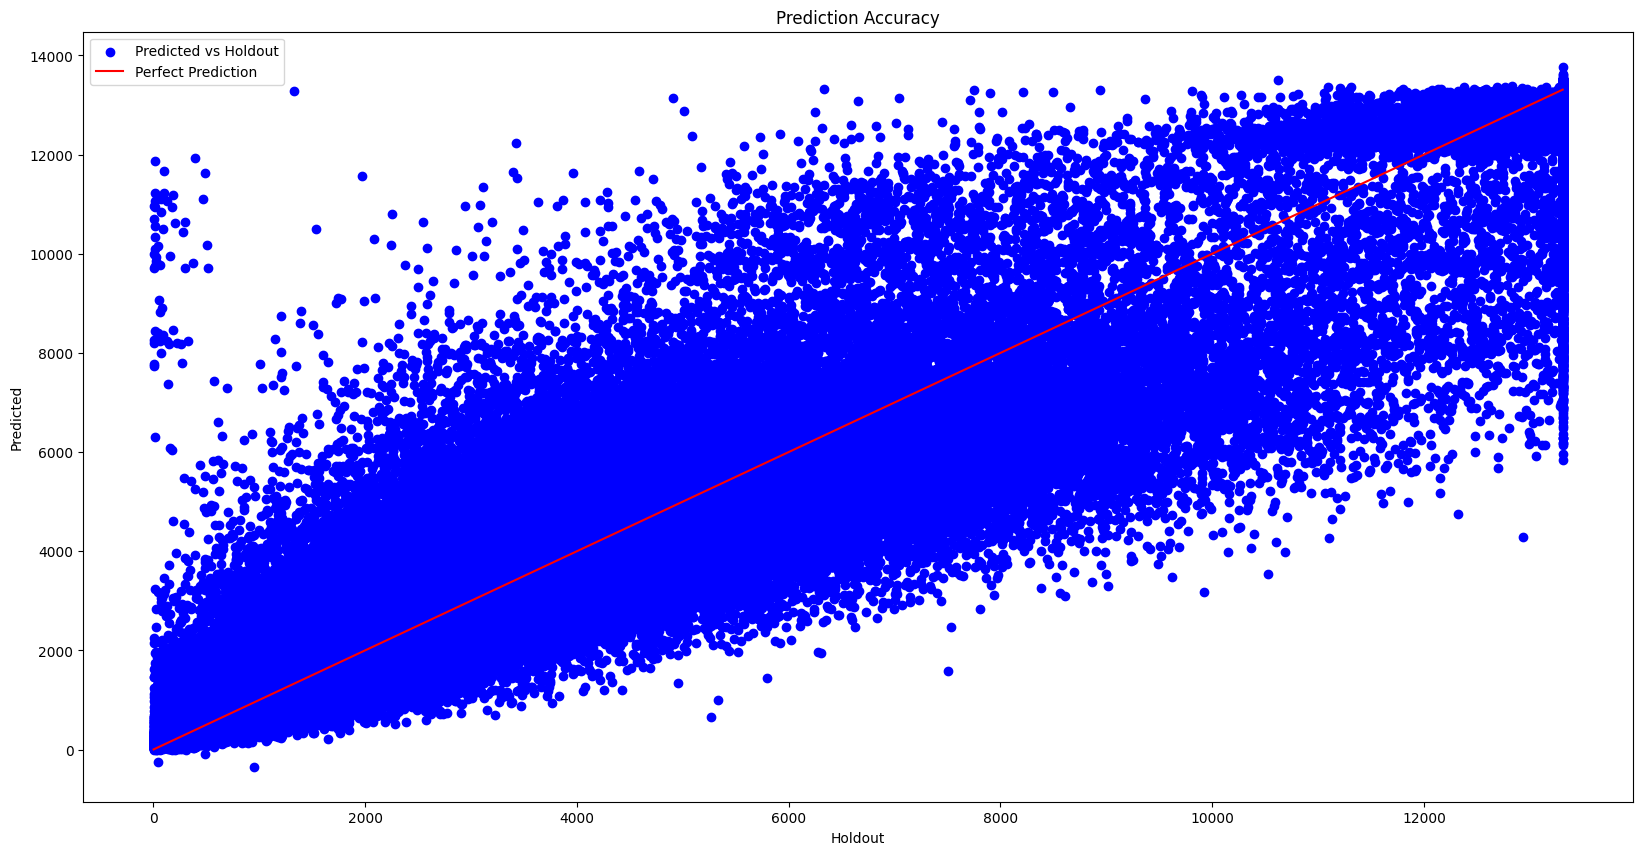

In [34]:
# Plot the predicted values against the holdout values
plt.figure(figsize=(20,10))
plt.scatter(df_predictions['Holdout'], df_predictions['Predicted'], c='blue', label='Predicted vs Holdout')

# Add a reference line
plt.plot([df_predictions['Holdout'].min(), df_predictions['Holdout'].max()], [df_predictions['Holdout'].min(), df_predictions['Holdout'].max()], c='red', label='Perfect Prediction')

# Set labels and title
plt.xlabel('Holdout')
plt.ylabel('Predicted')
plt.title('Prediction Accuracy')

# Show the legend
plt.legend()

# Display the plot
plt.show()

# New

In [45]:
X_final_scaled=session.sql('Select * from "Sales_Forecast_Training_Data"').to_pandas()

X_final_scaled.rename(columns={"Profit": "Revenue"},inplace=True)

In [46]:
X_final_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540201 entries, 0 to 540200
Data columns (total 38 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   TRUCK_ID                                  540201 non-null  int8   
 1   MONTH                                     540201 non-null  int8   
 2   HOUR                                      540201 non-null  int8   
 3   DOW                                       540201 non-null  int8   
 4   DAY                                       540201 non-null  int8   
 5   PUBLIC_HOLIDAY                            540201 non-null  int8   
 6   Revenue                                   540201 non-null  float64
 7   LAT                                       540201 non-null  float64
 8   LONG                                      540201 non-null  float64
 9   LOCATION_ID                               540201 non-null  int16  
 10  SUM_DAY_OF_WEEK_AVG_

In [47]:
def trim_outliers(dataframe, column, lower_percentile=0.01, upper_percentile=0.99):
    lower_bound = dataframe[column].quantile(lower_percentile)
    upper_bound = dataframe[column].quantile(upper_percentile)
    return dataframe[(dataframe[column] >= lower_bound) & (dataframe[column] <= upper_bound)]

def log_transform(dataframe, column):
    dataframe[column] = np.log1p(dataframe[column])
    return dataframe

# Trim outliers from X_final_scaled dataset
X_final_scaled_trimmed = trim_outliers(X_final_scaled, 'Revenue')

# Perform log transformation on 'Revenue' column
X_final_scaled_trimmed_log = log_transform(X_final_scaled_trimmed, 'Revenue')

X_final_scaled = X_final_scaled_trimmed_log

C:\Users\Jammie99\AppData\Local\Temp\ipykernel_15552\186859248.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[column] = np.log1p(dataframe[column])


In [48]:
# Split the dataset into features (X) and target (y)
X = X_final_scaled.drop("Revenue",axis=1)
y = X_final_scaled["Revenue"]

# Split the dataset into training and testing datasets
X_training, X_holdout, y_training, y_holdout = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_training, y_training, test_size=0.2, random_state=42)

In [49]:
xgb = XGBRegressor(objective="reg:squarederror", learning_rate=0.01523, max_depth=9, colsample_bytree=0.578, n_estimators=641, subsample=0.854)
xgb.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])

c:\Users\Jammie99\anaconda3\envs\pysnowpark\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[0]	validation_0-rmse:7.57599
[1]	validation_0-rmse:7.46129
[2]	validation_0-rmse:7.34817
[3]	validation_0-rmse:7.23695
[4]	validation_0-rmse:7.12739
[5]	validation_0-rmse:7.01938
[6]	validation_0-rmse:6.91345
[7]	validation_0-rmse:6.80871
[8]	validation_0-rmse:6.70558
[9]	validation_0-rmse:6.60403
[10]	validation_0-rmse:6.50408
[11]	validation_0-rmse:6.40561
[12]	validation_0-rmse:6.30911
[13]	validation_0-rmse:6.21404
[14]	validation_0-rmse:6.12050
[15]	validation_0-rmse:6.02797
[16]	validation_0-rmse:5.93677
[17]	validation_0-rmse:5.84706
[18]	validation_0-rmse:5.75864
[19]	validation_0-rmse:5.67202
[20]	validation_0-rmse:5.58674
[21]	validation_0-rmse:5.50274
[22]	validation_0-rmse:5.41967
[23]	validation_0-rmse:5.33779
[24]	validation_0-rmse:5.25719
[25]	validation_0-rmse:5.17823
[26]	validation_0-rmse:5.10015
[27]	validation_0-rmse:5.02360
[28]	validation_0-rmse:4.94825
[29]	validation_0-rmse:4.87362
[30]	validation_0-rmse:4.80063
[31]	validation_0-rmse:4.72827
[32]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.578,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01523,
             max_delta_step=0, max_depth=9, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=641, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.854,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
print('Train MSE is: ', mean_squared_error(xgb.predict(X_train), y_train))
print('Test MSE is: ', mean_squared_error(xgb.predict(X_test), y_test))
print()
print('Train RMSE is: ',  math.sqrt(mean_squared_error(xgb.predict(X_train), y_train)))
print('Test RMSE is: ', math.sqrt(mean_squared_error(xgb.predict(X_test), y_test)))
print()
print('Train MAE is: ', mean_absolute_error(xgb.predict(X_train), y_train))
print('Test MAE is: ', mean_absolute_error(xgb.predict(X_test), y_test))
print()
print('Train R2 is: ', r2_score(xgb.predict(X_train), y_train))
print('Test R2 is: ', r2_score(xgb.predict(X_test), y_test))

Train MSE is:  0.19254913697432444
Test MSE is:  0.21472567022589134

Train RMSE is:  0.43880421257586444
Test RMSE is:  0.463385012949158

Train MAE is:  0.3113427798063588
Test MAE is:  0.32609491134341784

Train R2 is:  0.8587955677659646
Test R2 is:  0.8424024976855247


In [51]:
# Create a DataFrame with holdout values and predicted values
df_predictions = X_holdout.copy()
df_predictions['Holdout'] = np.expm1(y_holdout)
holdout_predictions = np.expm1(xgb.predict(X_holdout)) #Reverse log transformation
df_predictions['Predicted'] = holdout_predictions

# Add a column for the differences
df_predictions['Difference'] = df_predictions['Predicted'] - df_predictions['Holdout']

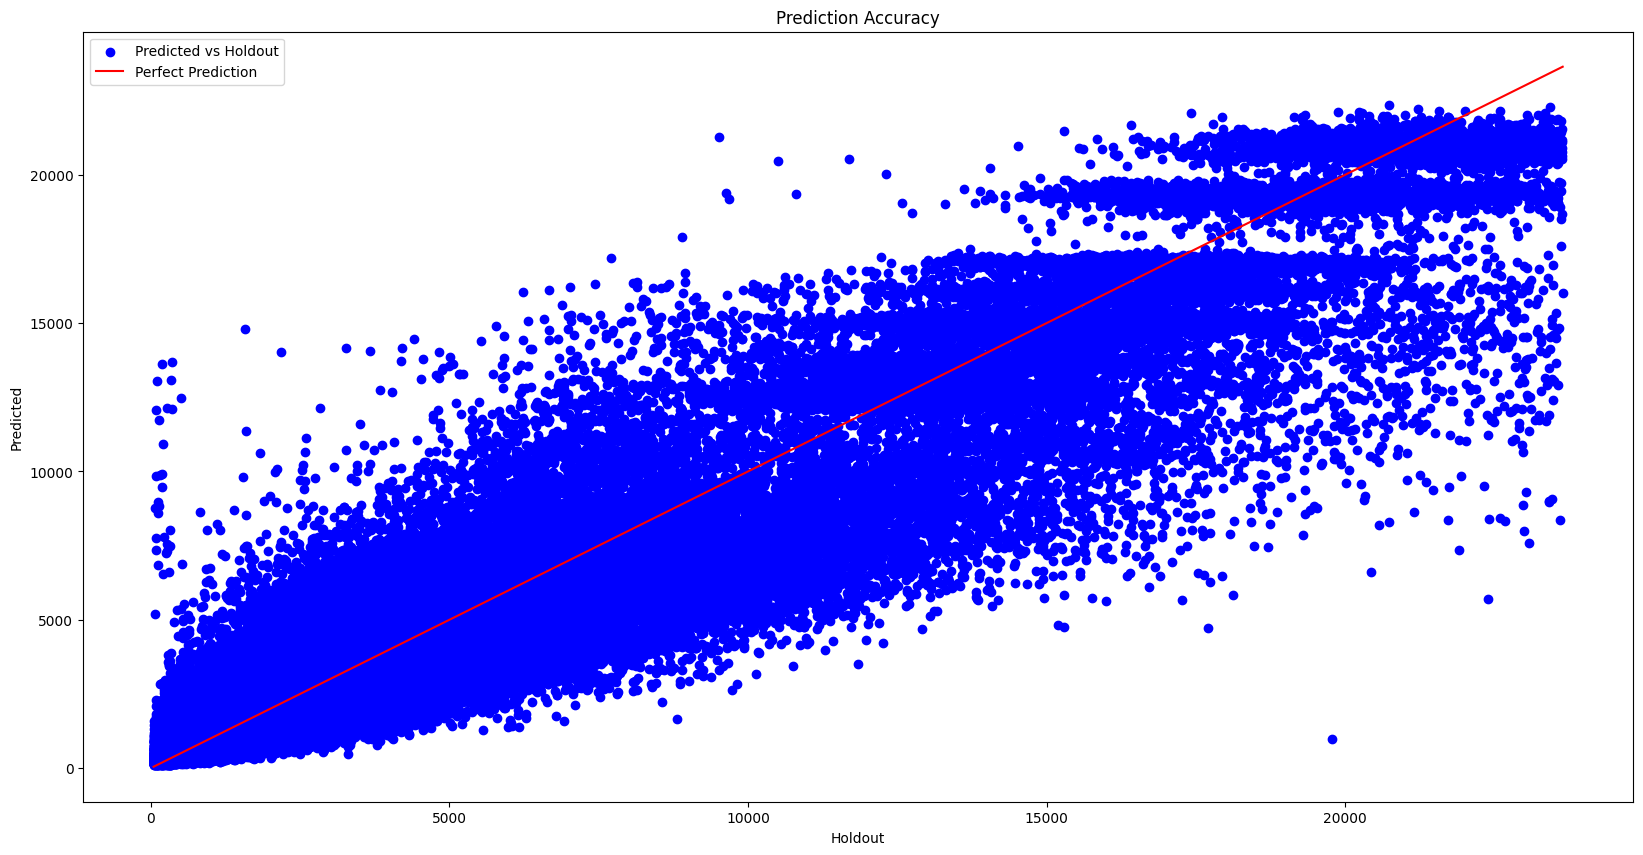

In [52]:
import matplotlib.pyplot as plt

# Plot the predicted values against the holdout values
plt.figure(figsize=(20,10))
plt.scatter(df_predictions['Holdout'], df_predictions['Predicted'], c='blue', label='Predicted vs Holdout')

# Add a reference line
plt.plot([df_predictions['Holdout'].min(), df_predictions['Holdout'].max()], [df_predictions['Holdout'].min(), df_predictions['Holdout'].max()], c='red', label='Perfect Prediction')

# Set labels and title
plt.xlabel('Holdout')
plt.ylabel('Predicted')
plt.title('Prediction Accuracy')

# Show the legend
plt.legend()

# Display the plot
plt.show()